In [1]:
import torch
from SingleSessionSingleTrialDataset import SingleSessionSingleTrialDataset
import numpy as np
from pynwb import NWBHDF5IO

import os

dataset_path = "000070"
nwb_file_path = os.path.join(
    dataset_path, "sub-Jenkins", "sub-Jenkins_ses-20090916_behavior+ecephys.nwb")
io = NWBHDF5IO(nwb_file_path, 'r')
nwb_file = io.read()
hand_data = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].data[:]
hand_timestamps = nwb_file.processing['behavior'].data_interfaces['Position']['Hand'].timestamps[:]
trial_data = nwb_file.intervals['trials']

unit_spike_times = [nwb_file.units[unit_id]['spike_times'].iloc[0][:]
                    for unit_id in range(len(nwb_file.units))]
n_neurons = len(unit_spike_times)
n_context_bins = 50

n_trials = 2000
datasets = [SingleSessionSingleTrialDataset(
    trial_data, hand_data, hand_timestamps, unit_spike_times, trial_id, bin_size=0.02, n_context_bins=n_context_bins) for trial_id in range(n_trials)]
dataset = torch.utils.data.ConcatDataset(datasets)
print(f"Dataset from {n_trials} trials has {len(dataset)} samples")

/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.3.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/dima/code/marvin/venv/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Dataset from 2000 trials has 200446 samples


In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert dataset to PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = []
y = []
for i in range(len(dataset)):
    features, labels = dataset[i]
    X.append(features[:].flatten())
    y.append(labels)
X = torch.stack(X).to(device)
y = torch.stack(y).to(device)

# Split into train/test
split_idx = int(0.9 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [5]:

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200)

# Define model
input_size = n_neurons * n_context_bins
model = nn.Sequential(
    nn.Linear(input_size, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
).to(device)

# Training parameters
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 20

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        train_pred = model(X_train)
        test_pred = model(X_test)
        
        train_r2 = 1 - ((y_train - train_pred)**2).mean() / ((y_train - y_train.mean())**2).mean()
        test_r2 = 1 - ((y_test - test_pred)**2).mean() / ((y_test - y_test.mean())**2).mean()
        
        # Separate R² scores for x and y coordinates
        train_r2_x = 1 - ((y_train[:,0] - train_pred[:,0])**2).mean() / ((y_train[:,0] - y_train[:,0].mean())**2).mean()
        train_r2_y = 1 - ((y_train[:,1] - train_pred[:,1])**2).mean() / ((y_train[:,1] - y_train[:,1].mean())**2).mean()
        test_r2_x = 1 - ((y_test[:,0] - test_pred[:,0])**2).mean() / ((y_test[:,0] - y_test[:,0].mean())**2).mean()
        test_r2_y = 1 - ((y_test[:,1] - test_pred[:,1])**2).mean() / ((y_test[:,1] - y_test[:,1].mean())**2).mean()
    
    if (epoch + 1) % 1 == 0:
        print(f"\nEpoch {epoch+1}/{n_epochs} | Train R²: {train_r2:.3f} | Test R²: {test_r2:.3f}")
        print(f"\t\tTrain R² (x,y): ({train_r2_x:.3f}, {train_r2_y:.3f}) | Test R² (x,y): ({test_r2_x:.3f}, {test_r2_y:.3f})")



Epoch 1/20 | Train R²: 0.583 | Test R²: 0.515
		Train R² (x,y): (0.651, 0.464) | Test R² (x,y): (0.634, 0.318)

Epoch 2/20 | Train R²: 0.734 | Test R²: 0.714
		Train R² (x,y): (0.793, 0.632) | Test R² (x,y): (0.767, 0.625)

Epoch 3/20 | Train R²: 0.799 | Test R²: 0.751
		Train R² (x,y): (0.873, 0.673) | Test R² (x,y): (0.810, 0.653)

Epoch 4/20 | Train R²: -0.010 | Test R²: -0.211
		Train R² (x,y): (0.185, -0.345) | Test R² (x,y): (0.071, -0.677)

Epoch 5/20 | Train R²: 0.848 | Test R²: 0.770
		Train R² (x,y): (0.844, 0.854) | Test R² (x,y): (0.761, 0.782)

Epoch 6/20 | Train R²: 0.917 | Test R²: 0.876
		Train R² (x,y): (0.915, 0.917) | Test R² (x,y): (0.881, 0.867)

Epoch 7/20 | Train R²: 0.939 | Test R²: 0.891
		Train R² (x,y): (0.957, 0.908) | Test R² (x,y): (0.922, 0.840)

Epoch 8/20 | Train R²: 0.528 | Test R²: 0.423
		Train R² (x,y): (0.367, 0.787) | Test R² (x,y): (0.224, 0.737)

Epoch 9/20 | Train R²: 0.950 | Test R²: 0.904
		Train R² (x,y): (0.959, 0.936) | Test R² (x,y): (0.

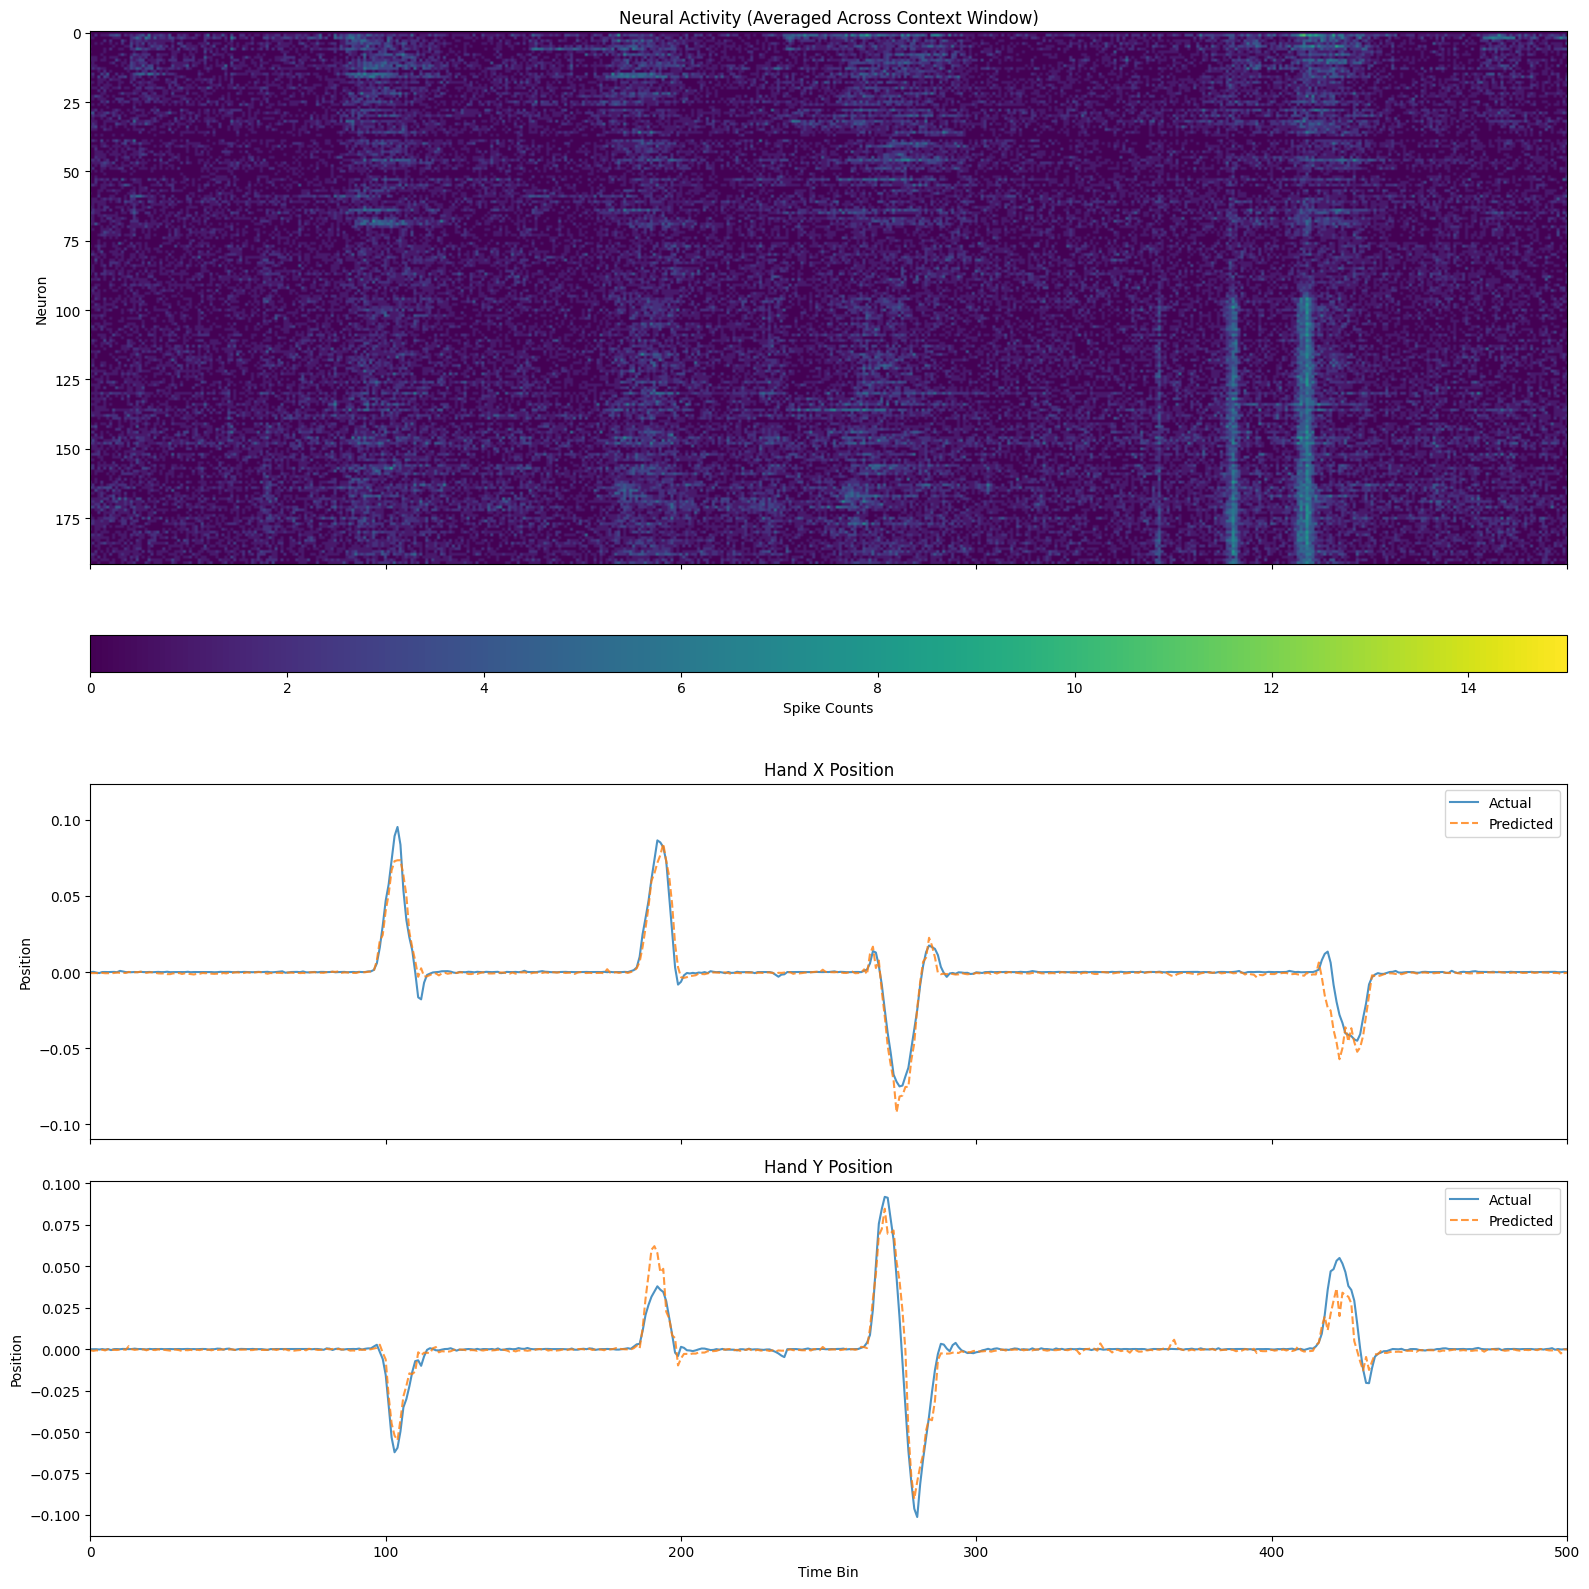

In [9]:
with torch.no_grad():
    test_pred = model(X_test).cpu().numpy()

# Convert dataset to numpy arrays and visualize
import matplotlib.pyplot as plt

# Create figure with subplots and shared x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 16), height_ratios=[2, 1, 1], sharex=True)

# Plot heatmap of X
im = ax1.imshow(X_test.reshape(-1, n_neurons, n_context_bins)[:, :, -1].T, aspect='auto', cmap='viridis')
ax1.set_title('Neural Activity (Averaged Across Context Window)')
ax1.set_ylabel('Neuron')
# Add smaller colorbar at the top
cbar = plt.colorbar(im, ax=ax1, orientation='horizontal', pad=0.1, aspect=40, label='Spike Counts')

# Plot x coordinate
ax2.plot(y_test[:, 0], label='Actual', alpha=0.8)
ax2.plot(test_pred[:, 0], label='Predicted', alpha=0.8, linestyle='--')
ax2.set_title('Hand X Position')
ax2.set_ylabel('Position')
ax2.legend()

# Plot y coordinate
ax3.plot(y_test[:, 1], label='Actual', alpha=0.8)
ax3.plot(test_pred[:, 1], label='Predicted', alpha=0.8, linestyle='--')
ax3.set_title('Hand Y Position')
ax3.set_xlabel('Time Bin')
ax3.set_ylabel('Position')
ax3.legend()

limit_time_bins = 500
ax1.set_xlim(0, limit_time_bins)
ax2.set_xlim(0, limit_time_bins)
ax3.set_xlim(0, limit_time_bins)

plt.tight_layout()
plt.show()


In [10]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'trained_mlp_model.pth')
